In [1]:
import torch
import torch.nn as nn
import numpy as np
import json
import urllib
from skimage.draw import polygon
from torchvision.models.detection.image_list import ImageList
from torchvision.models.detection import retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda"

device

'cuda'

In [3]:
image_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

In [4]:
def view_image(image, masks=None):
    # Display grayscale image: permute C, H, W to H, W, C for plt.imshow
    plt.imshow(torch.permute(image, (1, 2, 0)), cmap='gray')

    if masks is not None:
        # masks shape: (n, h, w)
        n = masks.shape[0]

        # Choose a colormap with distinct colors for multiple masks
        # colors = plt.cm.get_cmap('hsv', n)
        colors = plt.get_cmap('hsv', n)

        # Overlay each mask with some transparency
        for i in range(n):
            mask = masks[i].cpu().numpy()
            # Create an RGBA image where mask pixels are colored
            colored_mask = np.zeros((mask.shape[0], mask.shape[1], 4))
            colored_mask[:, :, :3] = colors(i)[:3]  # RGB from colormap
            colored_mask[:, :, 3] = mask * 0.4  # Alpha channel scaled by mask (opacity 0.4)

            plt.imshow(colored_mask, interpolation='none')

    # plt.axis('off')
    plt.show()

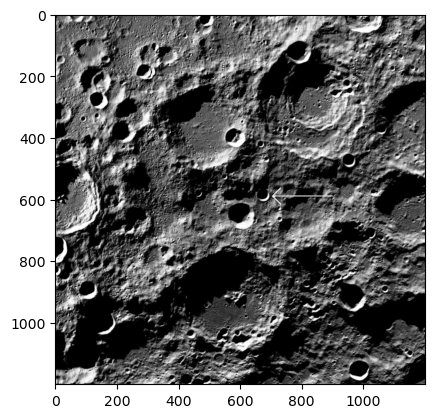

In [5]:
# this is a test image for getting an idea of the dimensions of the outputs of the layers
url = "https://raw.githubusercontent.com/aami-sagnik/lunar-crater-detection/refs/heads/main/crater.png"
urllib.request.urlretrieve(url, "crater.png")
img1 = image_transforms(Image.open("./crater.png"))
view_image(img1)

In [6]:
def get_masks_from_json(json_name, w, h):
  data_dict = json.load(open(json_name))
  polygon_points = [e["points"] for e in data_dict["crater.png"]]
  masks = torch.zeros((len(polygon_points), w, h), dtype=torch.float)

  for i in range(len(masks)):
    polygon_np = np.array(polygon_points[i])
    r = polygon_np[:, 1]
    c = polygon_np[:, 0]

    # get polygon interior indices
    rr, cc = polygon(r, c, shape=(w, h))

    # fill polygon area with ones
    masks[i, rr, cc] = 1

  return masks

In [7]:
# this is a test annotation
url = "https://raw.githubusercontent.com/aami-sagnik/lunar-crater-detection/refs/heads/main/crater_annotations.json"
urllib.request.urlretrieve(url, "crater_annotations.json")
masks = get_masks_from_json("crater_annotations.json", w=1200, h=1200)

In [8]:
images = torch.stack([img1, img1.clone()]) # creating a batch of images

In [9]:
masks = [masks, masks.clone()] # creating a batch of annotations

In [10]:
def resize_images_masks(images, masks, w, h):
  resize_transform = transforms.Resize((h, w))

  new_images = resize_transform(images)

  new_masks = []

  for m in masks:
    m = m.unsqueeze(1)
    resized_masks = F.interpolate(m, size=(h, w), mode='nearest')
    resized_masks = resized_masks.squeeze(1)
    new_masks.append((resized_masks > 0.5).float())

  return (new_images, new_masks)

In [11]:
images, masks = resize_images_masks(images, masks, 600, 600)

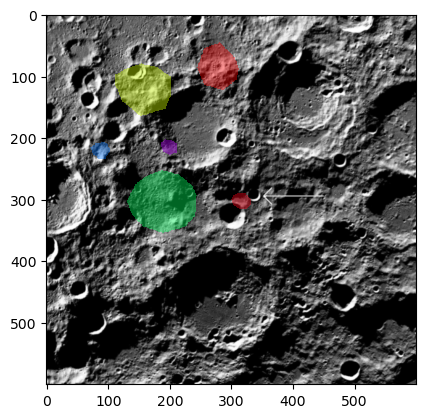

In [12]:
view_image(images[0], masks[0])

In [ ]:
class FPSNet(nn.Module):
    def __init__(self, n_att=5, n_stuff=1):
        super(FPSNet, self).__init__()
        retina_net_weights = RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT # TODO: use weights after training the retinanet with crater images
        self.retina_net = retinanet_resnet50_fpn_v2(weights=retina_net_weights)
        old_conv = self.retina_net.backbone.body.conv1
        self.retina_net.backbone.body.conv1 = nn.Conv2d(1,
                                                        old_conv.out_channels,
                                                        kernel_size=old_conv.kernel_size,
                                                        stride=old_conv.stride,
                                                        padding=old_conv.padding,
                                                        bias=old_conv.bias)

        self.fpn = self.retina_net.backbone
        self.upsample_f_5 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding="same"),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(128, 128, 3, padding="same"),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        )
        self.upsample_f_4 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding="same"),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        )
        self.upsample_f_3 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding="same"),
            nn.ReLU(),
        )
        # self.upsample_out = nn.Upsample(size=(w,h), mode='bilinear', align_corners=False)
        self.detection_head = self.retina_net.head
        self.anchor_generator = self.retina_net.anchor_generator
        self.postprocess_detections = self.retina_net.postprocess_detections
        self.n_att = n_att
        self.n_stuff = n_stuff
        self.n_out = 0

        if (self.n_att > 0):
          self.n_out += self.n_att + 1
        if (self.n_stuff > 0):
          self.n_out += self.n_stuff + 1

        self.pre_panoptic_head = nn.Sequential(
            nn.Conv2d(128 + self.n_att, 128, 3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.panoptic_head = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 128, 3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 128, 3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 128, 3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, self.n_out, 1)
        )

    def to_single_fmap(self, fmaps):
        f_3 = fmaps[0]
        f_4 = fmaps[1]
        f_5 = fmaps[2]

        resized_maps = [
            self.upsample_f_3(f_3),
            self.upsample_f_4(f_4),
            self.upsample_f_5(f_5),
        ]

        # Find minimum height and width
        min_h = min([f.shape[2] for f in resized_maps])
        min_w = min([f.shape[3] for f in resized_maps])

        # Crop to same size
        cropped_maps = [f[..., :min_h, :min_w] for f in resized_maps]

        aggregated_map = sum(cropped_maps)
        return aggregated_map


    def generate_detections(self, fmaps, images):
        head_outputs = self.detection_head(fmaps)

        image_sizes = [(img.shape[1], img.shape[2]) for img in images]
        image_list = ImageList(images, image_sizes)

        anchors = self.anchor_generator(image_list, fmaps)

        num_anchors_per_level = [x.size(2) * x.size(3) for x in fmaps]
        HW = 0
        for v in num_anchors_per_level:
            HW += v
        HWA = head_outputs["cls_logits"].size(1)
        A = HWA // HW
        num_anchors_per_level = [hw * A for hw in num_anchors_per_level]

        # split outputs per level
        split_head_outputs: dict[str, list[torch.Tensor]] = {}
        for k in head_outputs:
            split_head_outputs[k] = list(head_outputs[k].split(num_anchors_per_level, dim=1))
        split_anchors = [list(a.split(num_anchors_per_level)) for a in anchors]

        # compute the detections
        detections = self.postprocess_detections(split_head_outputs, split_anchors, image_list.image_sizes)

        return detections

    def soft_attention_mask(self, mu, C, box_dim, mask_w, mask_h):
        # mu: (2,) tensor, C: (2,2) tensor, w, h, n: ints

        # Create n x n grid
        ys = torch.arange(mask_h, dtype=torch.float32).to(mu.device)
        xs = torch.arange(mask_w, dtype=torch.float32).to(mu.device)
        grid_y, grid_x = torch.meshgrid(ys, xs, indexing='ij')
        coords = torch.stack([grid_y, grid_x], dim=-1)  # shape: (n, n, 2)

        # Bounding box coordinates
        y1 = int(mu[0] - box_dim[1] // 2)
        y2 = int(mu[0] + box_dim[1] // 2)
        x1 = int(mu[1] - box_dim[0] // 2)
        x2 = int(mu[1] + box_dim[0] // 2)

        # Mask for bounding box: True inside the box
        mask_box = (
            (grid_y >= y1) & (grid_y < y2) &
            (grid_x >= x1) & (grid_x < x2)
        )

        # Flatten grid for Gaussian
        coords_flat = coords.reshape(-1, 2)  # (n*n, 2)
        mvn = torch.distributions.MultivariateNormal(mu, C)
        gauss_flat = torch.exp(mvn.log_prob(coords_flat))  # (n*n,)

        # Restore mask shape
        gauss_mask = gauss_flat.reshape(mask_w, mask_h)
        gauss_mask *= mask_box  # zero outside the bounding box

        # Normalize soft mask
        gauss_mask /= gauss_mask.sum()

        return gauss_mask  # shape (n, n)

    def generate_attention_masks(self, boxes, scores, ms_w, ms_h, h_sf, w_sf, c_att=255):
        # x_sf, y_sf represent the x and y scaling factors respectively
        # x_sf * x_image_space = x_mask_space
        # y_sf * y_image_space = y_mask_space

        attention_masks = []
        attention_labels = []
        attention_scores = []

        included = 0

        for _ in range(self.n_att):
            if included < boxes.shape[0]:
                box = boxes[included]
                score = scores[included]

                mean = torch.Tensor([box[0].item()*h_sf, box[1].item()*w_sf]).to(device)
                mean = torch.floor(mean).to(device)
                box_dim = torch.Tensor([box[2].item()*h_sf, box[3].item()*w_sf]).to(device)
                box_dim = torch.floor(box_dim)
                C = torch.diag(box_dim).to(device)

                attention_mask = self.soft_attention_mask(mean, C, box_dim, ms_w, ms_h)

                attention_masks.append(attention_mask)
                attention_labels.append(torch.tensor(included).to(device))
                attention_scores.append(score)

                included += 1
            else:
                attention_masks.append(torch.zeros(ms_w, ms_h).to(device))
                attention_labels.append(torch.tensor(-1).to(device))
                attention_scores.append(torch.tensor(0).to(device))

        attention_masks = torch.stack(attention_masks).to(device)
        attention_labels = torch.stack(attention_labels).to(device)
        attention_scores = torch.stack(attention_scores).to(device)

        indices = torch.randperm(attention_masks.size(0))

        attention_masks = attention_masks[indices]
        attention_labels = attention_labels[indices]
        attention_scores = attention_scores[indices]

        attention_masks *= c_att

        return (attention_masks, attention_labels, attention_scores)

    def forward(self, images):
        fp = self.fpn(images) # getting the feature pyramid
        fmaps = list(fp.values())
        detections = self.generate_detections(fmaps, images) # generating bounding-boxes along with scores
        aggregated_maps = self.to_single_fmap(fmaps) # scaling and adding the feature maps to get a single feature map

        panoptic_features = []
        panoptic_labels = []
        panoptic_scores = []

        h = images.shape[2]
        w = images.shape[3]

        h_mask_sf = aggregated_maps.shape[2] / h
        w_mask_sf = aggregated_maps.shape[3] / w

        for i in range(images.shape[0]):
            detection = detections[i]
            aggregated_map = aggregated_maps[i]
            # "detection" represents boxes for one image in a batch
            # "aggregated_map" represents feature map for one image in a batch
            boxes = detection["boxes"]
            labels = detection["labels"]
            scores = detection["scores"]
            attention_masks, attention_labels, attention_scores = self.generate_attention_masks(boxes, scores, aggregated_map.shape[1], aggregated_map.shape[2], h_mask_sf, w_mask_sf) # generating attention masks from bounding boxes
            panoptic_feature_single = torch.cat([attention_masks, aggregated_map], dim=0) # generating panoptic features for one image

            # for batch processing multiple images at a time
            panoptic_features.append(panoptic_feature_single)
            panoptic_labels.append(attention_labels)
            panoptic_scores.append(attention_scores)

        panoptic_features = torch.stack(panoptic_features)
        # need to procees the panoptic features for one image at a time (for now)

        panoptic_features = self.pre_panoptic_head(panoptic_features)
        output = self.panoptic_head(panoptic_features)

        upscaled_output = F.interpolate(output, size=(h, w), mode='bilinear', align_corners=False)

        return {
            "values": upscaled_output,
            "labels": panoptic_labels,
            "scores": panoptic_scores
        }

In [14]:
model = FPSNet().to(device) # instantiating the model
output = model(images.to(device))

torch.Size([2, 128, 75, 75])


<Axes: >

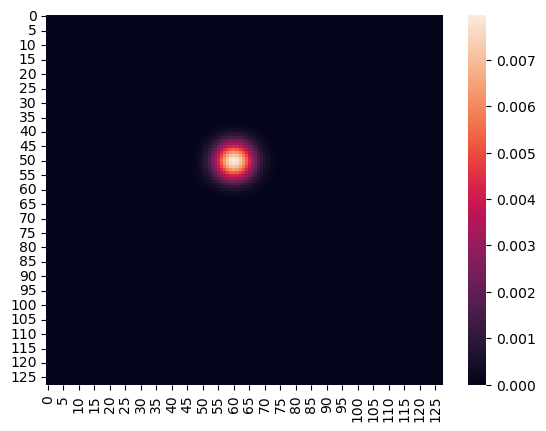

In [17]:
import seaborn as sns
# this is what the attention mask looks like (adjust mu, C, w and h to see the effect)
sns.heatmap(model.soft_attention_mask(torch.Tensor([50, 60]), torch.diag(torch.Tensor([20, 20])), torch.Tensor([30, 40]), 128, 128))

In [18]:
output["values"].shape

torch.Size([2, 8, 600, 600])

In [20]:
sm_values = torch.softmax(output["values"], dim=1)

In [28]:
max_indices = torch.argmax(sm_values, dim=1, keepdim=True)  # shape: (2, 1, 1200, 1200)

# Create a binary mask with 1 at max indices and 0 elsewhere
binary_masks = torch.zeros_like(sm_values).scatter_(1, max_indices, 1)

In [29]:
binary_masks.shape

torch.Size([2, 8, 600, 600])